In [28]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2017-05-31.csv')

In [46]:
df['Close'].head()

0    4.39
1     NaN
2     NaN
3     NaN
4     NaN
Name: Close, dtype: float64

In [47]:
df = df.iloc[731865:,:].copy()

In [48]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
731865,1369229820,118.39,118.39,118.39,118.39,0.048600,5.753754,118.39000
731866,1369229880,118.39,118.39,118.39,118.39,0.048600,5.753754,118.39000
731867,1369229940,118.39,118.39,118.39,118.39,0.072900,8.630631,118.39000
731868,1369230000,118.39,118.39,118.39,118.39,0.150053,17.764751,118.39000
731869,1369230060,118.39,118.39,118.00,118.00,9.447752,1116.122884,118.13635


In [49]:
df['Close'].shape

(316710,)

In [50]:
df['Close'] = df['Close'].ffill()

In [35]:
df_close = pd.Series(df['Close'])

In [36]:
df_close.shape

(316710,)

In [37]:
df_close.to_csv('close.csv')

In [11]:
#df.to_csv('processed_bitstampUSD_1-min_data_2012-01-01_to_2017-05-31.csv')

In [38]:
pd.isnull(df).sum()

Timestamp                0
Open                 83497
High                 83497
Low                  83497
Close                    0
Volume_(BTC)         83497
Volume_(Currency)    83497
Weighted_Price       83497
dtype: int64

In [39]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm #, time #helper libraries
import time

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [41]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [42]:
dataframe = pd.read_csv('close.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [43]:
dataset.shape

(316706, 1)

In [44]:
dataset

array([[ 118.38999939],
       [ 118.38999939],
       [ 118.38999939],
       ..., 
       [ 729.23999023],
       [ 734.54998779],
       [ 730.71002197]], dtype=float32)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1

In [11]:
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
#trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testX.shape

(696107, 30)

In [12]:
testY.shape

(696107,)

In [13]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
testX.shape

(696107, 1, 30)

In [15]:
trainX.shape

(1413339, 1, 30)

In [16]:
#trainX = trainX[-1000:,:,:]
#trainY = trainY[-1000:,]

In [16]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=3000, verbose=2)

Epoch 1/10
8s - loss: 3.9416e-04
Epoch 2/10
6s - loss: 2.2900e-06
Epoch 3/10
6s - loss: 1.8582e-06
Epoch 4/10
6s - loss: 1.8128e-06
Epoch 5/10
6s - loss: 1.7765e-06
Epoch 6/10
6s - loss: 1.7315e-06
Epoch 7/10
6s - loss: 1.6749e-06
Epoch 8/10
5s - loss: 1.6068e-06
Epoch 9/10
6s - loss: 1.5242e-06
Epoch 10/10
6s - loss: 1.4264e-06


In [17]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [18]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.22 RMSE
Test Score: 43.99 RMSE


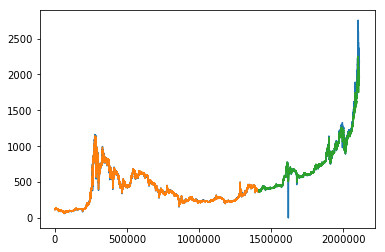

In [24]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
testPredict[-6600]

array([ 2153.68164062], dtype=float32)

In [49]:
testY[:,-6600]

array([ 2519.48996745])

In [50]:
df = pd.read_csv('close.csv')

In [ ]:
close_new = pd.DataFrame(df.iloc[:,:])